# Hybrid Embedding then Non-Embedding Approaches
* Pipeline 1: Finetune BERT > VAE (binary classification: known vs open) > fewshot (multi-class classification on known subset)
* Pipeline 2: Finetune BERT ? fewshot (multi-class classification on full dataset)
* For more information about the 2 pipelines, please visit the "Step 5 Run 2 Separate Fewshot Pipelines/Experiments" section of this notebook

# Import Libraries, Tokens/API Keys

In [ ]:
import random
import os
import pandas as pd

import numpy as np
import numpy
# In NumPy 1.24, numpy removed aliases np.object and np.bool.
# Some older code/libraries still reference numpy.object and numpy.bool and will crash with AttributeError.
# setattr patches NumPy to restore numpy.object, pointing it to Python’s built‑in object, matching the old behavior.
#         do the same for numpy.bool
setattr(numpy, 'object', object)
setattr(numpy, 'bool', bool)

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from transformers import BertTokenizerFast, BertModel, Trainer, TrainingArguments
from datasets import load_dataset, Dataset, DatasetDict

# progress bar
# from tqdm import tqdm

In [ ]:
##########################
# when running on kaggle
##########################
import wandb
from kaggle_secrets import UserSecretsClient

# Get the WandB API key from Kaggle secrets
user_secrets = UserSecretsClient()
wandb_api_key = user_secrets.get_secret("WANDB_TOKEN")

# Log in to wandb with the API key
wandb.login(key=wandb_api_key)

In [ ]:
PRETRAINED_MODEL_NAME = "bert-base-uncased"
MODEL_DIR_BERT = "./finetunebert_banking77"
MODEL_DIR_VAE = "./trainvae_banking77"
BATCH_SIZE = 128
LR_PRETRAIN = 2e-5
EPOCHS_PRETRAIN = 20
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
MAX_LEN = 128


# Load Dataset

In [ ]:
dataset = load_dataset("banking77")
tokenizer = BertTokenizerFast.from_pretrained(PRETRAINED_MODEL_NAME)

def tokenize_fn(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=MAX_LEN)

dataset = dataset.map(tokenize_fn, batched=True)


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/298k [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/93.9k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/10003 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3080 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Map:   0%|          | 0/10003 [00:00<?, ? examples/s]

Map:   0%|          | 0/3080 [00:00<?, ? examples/s]

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 10003
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 3080
    })
})

In [ ]:
print(dataset['train'].features['label'].names)

['activate_my_card', 'age_limit', 'apple_pay_or_google_pay', 'atm_support', 'automatic_top_up', 'balance_not_updated_after_bank_transfer', 'balance_not_updated_after_cheque_or_cash_deposit', 'beneficiary_not_allowed', 'cancel_transfer', 'card_about_to_expire', 'card_acceptance', 'card_arrival', 'card_delivery_estimate', 'card_linking', 'card_not_working', 'card_payment_fee_charged', 'card_payment_not_recognised', 'card_payment_wrong_exchange_rate', 'card_swallowed', 'cash_withdrawal_charge', 'cash_withdrawal_not_recognised', 'change_pin', 'compromised_card', 'contactless_not_working', 'country_support', 'declined_card_payment', 'declined_cash_withdrawal', 'declined_transfer', 'direct_debit_payment_not_recognised', 'disposable_card_limits', 'edit_personal_details', 'exchange_charge', 'exchange_rate', 'exchange_via_app', 'extra_charge_on_statement', 'failed_transfer', 'fiat_currency_support', 'get_disposable_virtual_card', 'get_physical_card', 'getting_spare_card', 'getting_virtual_card'

In [ ]:
len(dataset['train'].features['label'].names)

77

In [ ]:
dataset['train']['label']

Column([11, 11, 11, 11, 11])

In [ ]:
dataset['train'][0].keys()

dict_keys(['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'])

In [ ]:
# for split in ["train", "test"]:
#     dataset[split].set_format(type="torch", columns=["input_ids","attention_mask","label"])

In [ ]:
# compare sequence of records to TSV using 3 sample records

# huggingface 'train' = thuiar train.tsv AND dev.tsv
# https://github.com/thuiar/Adaptive-Decision-Boundary/blob/main/data/banking/train.tsv
# text  label
# Could you help my figure out the exchange fee?        exchange_charge
# I made a cash deposit to my account but i don't see it        balance_not_updated_after_cheque_or_cash_deposit
# Hello - I'm on the app and trying to purchase crypto. It's not going through. What am I doing wrong?  beneficiary_not_allowed

print(f"example 1: {dataset['train'][0]['text']}")
print(f"example 2: {dataset['train'][1]['text']}")
print(f"example 3: {dataset['train'][2]['text']}")

example 1: I am still waiting on my card?
example 2: What can I do if my card still hasn't arrived after 2 weeks?
example 3: I have been waiting over a week. Is the card still coming?


In [ ]:
# huggingface 'test' = thuiar test.tsv
# https://github.com/thuiar/Adaptive-Decision-Boundary/blob/main/data/banking/test.tsv
# text	label
# Can I exchange currencies with this app?	exchange_via_app
# My daughter would like a card as well, how can we make this happen?	getting_spare_card
# What countries can I travel to and have access to their currencies?	fiat_currency_support

print(f"example 1: {dataset['test'][0]['text']}")
print(f"example 2: {dataset['test'][1]['text']}")
print(f"example 3: {dataset['test'][2]['text']}")


example 1: How do I locate my card?
example 2: I still have not received my new card, I ordered over a week ago.
example 3: I ordered a card but it has not arrived. Help please!


## Data preprocessing
* Random 25% OOS
* Curated 25% OOS - updated approach

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 10003
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 3080
    })
})

In [ ]:
# random 25% OOS
def make_open_set(dataset, label_column="label", open_fraction=0.25, seed=38):
    random.seed(seed)

    all_labels = sorted(np.unique(dataset["train"][label_column]))
    num_open = int(len(all_labels) * open_fraction)
    open_classes = set(random.sample(all_labels, num_open))                   # unknown intent = oos
    print(f"open classes {open_classes}")


    # TRAIN ON KNOWN INTENT/seen classes only
    seen_classes = [lbl for lbl in all_labels if lbl not in open_classes]
    train_filtered = dataset["train"].filter(lambda x: x[label_column] not in open_classes)


    # TEST SET - contains BOTH KNOWN INTENT AND OOS
    test_df = dataset["test"].to_pandas()
    # for OOS TEST SET - UPDATE 'label' INPLACE to -1
    test_df[label_column] = test_df[label_column].apply(lambda lbl: -1 if lbl in open_classes else lbl)
    print(f"modified {len(test_df[test_df[label_column] == -1])}")

    test_modified = Dataset.from_pandas(test_df)

    return DatasetDict({
        "train": train_filtered,
        "test": test_modified
    }), list(open_classes), seen_classes


In [ ]:
# Curated 25% OOS
# Define your OOS classes
list_oos_idx = [2, 10, 14, 15, 16, 17, 19, 25, 31, 32, 33, 34, 36, 52, 53, 54, 57, 73, 76]

# make_open_set_curated function
def make_open_set_curated(dataset, label_column="label", open_classes_list=None):
    all_labels = sorted(np.unique(dataset["train"][label_column]))

    # Use predefined list instead of random sample
    open_classes = set(open_classes_list)  # Convert to set for fast lookup

    print(f"Using custom open classes: {open_classes}")

    # Filter training set (exclude OOS classes)
    train_filtered = dataset["train"].filter(lambda x: x[label_column] not in open_classes)

    # Modify test set (relabel OOS classes as -1)
    test_df = dataset["test"].to_pandas()
    test_df[label_column] = test_df[label_column].apply(
        lambda lbl: -1 if lbl in open_classes else lbl
    )
    test_modified = Dataset.from_pandas(test_df)

    seen_classes = [lbl for lbl in all_labels if lbl not in open_classes]
    return DatasetDict({"train": train_filtered, "test": test_modified}), list(open_classes), seen_classes



In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 10003
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 3080
    })
})

In [ ]:
# random 25%
# new_dataset, open_classes, seen_classes = make_open_set(
#     dataset,
#     label_column='label',
#     open_fraction=0.25,
#     seed=0
# )

# curated 25%
# Call the function with your list
new_dataset, open_classes, seen_classes = make_open_set_curated(
    dataset,
    label_column='label',
    open_classes_list=list_oos_idx  # Pass your custom list here
)

Using custom open classes: {2, 10, 14, 15, 16, 17, 19, 25, 31, 32, 33, 34, 36, 52, 53, 54, 57, 73, 76}


Filter:   0%|          | 0/10003 [00:00<?, ? examples/s]

# Step 1 Finetune BERT
* Why use BERT and not other embedding models?
  * BERT - can be our default/baseline embedding model
  * In terms of future work, other embedding models can be tested (eg BAAI bge-base-en which is a more modern embedding model)
* Why finetune BERT on known (i.e. non-oos) classes instead of using it out of the box?
  * Finetune allows us to adapt BERT to each dataset's domain - Banking domain for Banking77 dataset in this case
  * We expect finetuning BERT will let it learn how to move sentences from the same class closer, and move sentences from different classes further apart, to give "higher quality embeddings", which can be used to better differentiate between different classes

In [ ]:
class BertMeanPoolClassifier(nn.Module):
    def __init__(self, pretrained_model_name, num_labels):
        super().__init__()
        self.bert = BertModel.from_pretrained(pretrained_model_name)
        hidden_size = self.bert.config.hidden_size
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(hidden_size, num_labels)

    def forward(self, input_ids, attention_mask, labels=None):
        # input_ids = 'sequence of token-vocab indexes' per input sentence
        # attention_mask
        #     actual input sentences can vary in length
        #     but BERT model needs inputs of fixed length
        #     so we need to add [PAD] tokens up to the fixed length -> that is found in the attention_mask
        #     0s for padding, 1s for real tokens
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)

        # last_hidden_state dims: (batch_size, sequence_length, hidden_size)
        #    batch_size = n_sentences
        #    sequence_length of the tokenised sentence
        #    hidden_size = embedding vector size eg 768 (for bert-base-uncased)
        #    contains the most refined, context-aware representation for each input token
        last_hidden = outputs.last_hidden_state

        # attention_mask: (batch_size, sequence_length)
        #     0s for padding, 1s for real tokens
        # attention_mask.unsqueeze(-1): Adds a new dimension at the end.
        #     Dims: (batch_size, sequence_length, 1)
        # .expand(last_hidden.size()): "Stretches" or "copies" the values in that last dimension (1) to match the shape of last_hidden.
        #     dims:The shape is now (batch_size, sequence_length, hidden_size)
        mask = attention_mask.unsqueeze(-1).expand(last_hidden.size()).float()

        # last_hidden * mask: Get which positions correspond to real tokens (1s) vs padding (0s)
        #      and padding does not affect the final representation
        # sum along 'sequence_length' dimension -> sum all 'meaningful' real token vectors per input sentence
        summed = torch.sum(last_hidden * mask, dim=1)
        # mask consists of 0s and 1s
        #      so sum along 'sequence_length' dimension => count of meaningful/real tokens per input sentence
        # clamp avoids division by 0 error later, which can cause NaNs
        #       '0' happens when there are 0 real tokens in the input sentence
        #       so clamp ensures a very small/min value of 1e-9 to avoid the 'division by 0 error'
        counts = torch.clamp(mask.sum(dim=1), min=1e-9)

        # mean pooling (across all tokens in a sentence)
        #      calculates the "average token embedding" for each sentence
        #      Dims: (batch_size, hidden_size)
        pooled = summed / counts
        pooled = self.dropout(pooled)
        # logits / raw unnormalised scores from the classifier
        logits = self.classifier(pooled)

        # during training, dataloader passes 'labels' to the BERT model
        if labels is not None:
            loss = F.cross_entropy(logits, labels)
            return loss, logits
        # else during inference, the dataloader does not pass 'labels' to the BERT model
        # also do this for 'any other scenarios' that we might not expect
        return logits

In [ ]:
from transformers import TrainerCallback

class LossTracker(TrainerCallback):
    def __init__(self):
        self.history = {
            "train_loss": [],
            "eval_loss": [],
            "eval_f1": []
        }

    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs is None:
            return

        if "loss" in logs:
            self.history["train_loss"].append(logs["loss"])
        if "eval_loss" in logs:
            self.history["eval_loss"].append(logs["eval_loss"])
        if "eval_f1" in logs:
            self.history["eval_f1"].append(logs["eval_f1"])


In [ ]:
tracker = LossTracker()

In [ ]:
# BERT Model
num_labels = dataset["train"].features["label"].num_classes
classifier_model = BertMeanPoolClassifier(PRETRAINED_MODEL_NAME, num_labels).to(DEVICE)

# Training Configuration
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    learning_rate=LR_PRETRAIN,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=EPOCHS_PRETRAIN,
    weight_decay=0.01,
    # checkpoint/save a max of the last 2 intermediate model weights
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [ ]:
from sklearn.metrics import f1_score

# Evaluate training process using Macro-F1
def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    return {"f1":f1_score(labels, preds, average='macro')}

In [ ]:
split = new_dataset["train"].train_test_split(test_size=0.2, seed=38)

# initialise trainer
trainer = Trainer(
    model=classifier_model,
    args=training_args,
    train_dataset=split["train"],
    eval_dataset=split["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[tracker]
)

/tmp/ipython-input-1477522139.py:4: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Tracking run with wandb version 0.20.1
wandb: Run data is saved locally in /kaggle/working/wandb/run-20250810_131944-zg4co83z
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run ./results
wandb: ⭐️ View project at https://wandb.ai/kaiquanmah0/huggingface
wandb: 🚀 View run at https://wandb.ai/kaiquanmah0/huggingface/runs/zg4co83z


Epoch,Training Loss,Validation Loss,F1
1,3.813000,2.907180,0.469757
2,2.235400,1.439982,0.682863
3,1.205300,0.859810,0.770287
4,0.718300,0.596180,0.840635
5,0.472900,0.485455,0.873392
6,0.331700,0.435367,0.887266
7,0.249100,0.399039,0.893812
8,0.183900,0.385617,0.900155
9,0.141900,0.381742,0.900264
10,0.108500,0.392008,0.897897


TrainOutput(global_step=920, training_loss=0.49588118299194006, metrics={'train_runtime': 1491.9875, 'train_samples_per_second': 78.714, 'train_steps_per_second': 0.617, 'total_flos': 0.0, 'train_loss': 0.49588118299194006, 'epoch': 20.0})

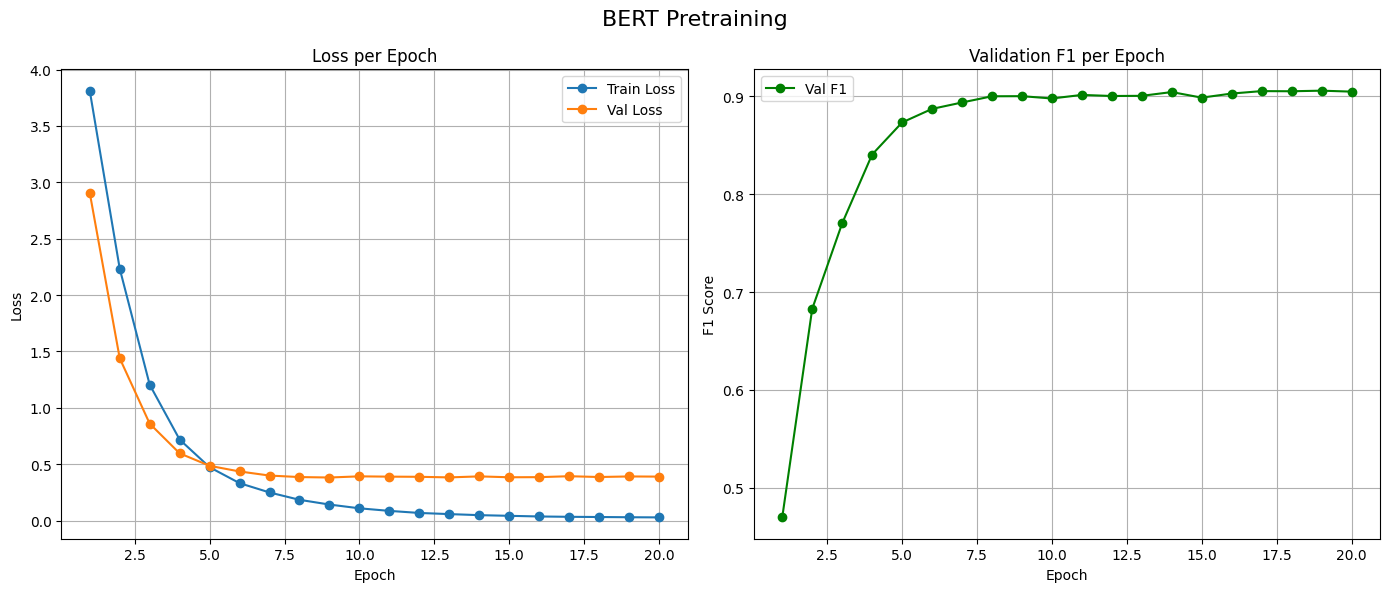

In [ ]:
import matplotlib.pyplot as plt

# Dummy values for illustration (replace with real tracker values)
epochs = list(range(1, len(tracker.history["train_loss"]) + 1))
train_loss = tracker.history["train_loss"][:30]
val_loss = tracker.history["eval_loss"][:30]
val_f1 = tracker.history.get("eval_f1", [])  # may need to be added in compute_metrics

# Create plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle("BERT Pretraining", fontsize=16)

# Loss plot
ax1.plot(epochs, train_loss, label="Train Loss", marker='o')
ax1.plot(epochs, val_loss, label="Val Loss", marker='o')
ax1.set_title("Loss per Epoch")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.grid(True)
ax1.legend()

# F1 plot
if val_f1:
    ax2.plot(epochs, val_f1, label="Val F1", color='green', marker='o')
    ax2.set_title("Validation F1 per Epoch")
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("F1 Score")
    ax2.grid(True)
    ax2.legend()
else:
    ax2.text(0.5, 0.5, "No F1 data available", ha='center', va='center', fontsize=12)
    ax2.set_title("Validation F1 per Epoch")
    ax2.axis('off')

plt.tight_layout()
plt.show()

From the plots above,
* Maybe we could have stopped training at epoch 8 - epoch 8 was already offering a good validation macro F1 score if 0.9, before plateauing with increasing number of epochs
* Epoch 8 also offers around 0.3856 validation loss, which does not decrease by much after that

In [ ]:
# save pretrained model and tokeniser files
os.makedirs(MODEL_DIR_BERT, exist_ok=True)
classifier_model.bert.save_pretrained(MODEL_DIR_BERT)
# also save the finetuned BERT classifier weights
torch.save(classifier_model.classifier.state_dict(), os.path.join(MODEL_DIR_BERT,"classifier.pt"))
tokenizer.save_pretrained(MODEL_DIR_BERT)

('./finetunebert_banking77/tokenizer_config.json',
 './finetunebert_banking77/special_tokens_map.json',
 './finetunebert_banking77/vocab.txt',
 './finetunebert_banking77/added_tokens.json',
 './finetunebert_banking77/tokenizer.json')

# Step 2 Variational Autoencoder (VAE)

## Load Pretrained BERT Tokenizer and Finetuned BERT Model

In [ ]:
from huggingface_hub import hf_hub_download
from transformers import BertTokenizerFast, BertModel
import torch
import os

# Define the Hugging Face repository ID
repo_id = "KaiquanMah/BERT-Banking77-OpenIntentClassification"

# Load the tokenizer
# uses
#   tokenizer.json
#   vocab.txt
#   special_tokens_map.json (defines special tokens like [CLS], [SEP], [PAD])
tokenizer = BertTokenizerFast.from_pretrained(repo_id)
print("Tokenizer loaded successfully.")


# Load the BERT model (this loads the model weights from model.safetensors and config.json)
# uses
#   config.json
#   model.safetensors - after finetuning
bert_model = BertModel.from_pretrained(repo_id)
print("BERT model loaded successfully.")



# To load the classifier state dictionary, you download the classifier.pt file
# then load it into the classifier model instance
classifier_state_dict_path = hf_hub_download(repo_id=repo_id, filename="classifier.pt")

# Initialise your BertMeanPoolClassifier
# extra information: input dimension (usually bert_model.config.hidden_size) and output dimension (num_labels)
num_labels = dataset["train"].features["label"].num_classes
classifier_model = BertMeanPoolClassifier(PRETRAINED_MODEL_NAME, num_labels).to(DEVICE)
# Load the state dictionary into the classifier part of the model
classifier_model.classifier.load_state_dict(torch.load(classifier_state_dict_path, map_location=DEVICE))
print("Classifier state dictionary loaded successfully.")


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

Tokenizer loaded successfully.


config.json:   0%|          | 0.00/618 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

BERT model loaded successfully.


classifier.pt:   0%|          | 0.00/238k [00:00<?, ?B/s]

Classifier state dictionary loaded successfully.


## Train VAE

In [ ]:
def get_bert_embedding(model, tokenizer, sentences, device, batch_size=16):
    # evaluation mode - disables Dropout, Normalisation layers during inference
    # to have a deterministic behaviour and output
    #     recap BERT architecture https://medium.com/analytics-vidhya/understanding-bert-architecture-3f35a264b187
    #                             https://huggingface.co/blog/bert-101
    model.eval()
    all_embeddings = []

    for i in range(0, len(sentences), batch_size):
        # batch of sentences
        batch = sentences[i:i+batch_size]
        # tokenise sentences
        inputs = tokenizer(batch, return_tensors="pt", padding=True, truncation=True, max_length=128)
        input_ids = inputs["input_ids"].to(device)
        attention_mask = inputs["attention_mask"].to(device)


        # repeat what we did when finetuning BERT
        # to generate 'averaged vector embeddings' per sentence
        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            last_hidden = outputs.last_hidden_state
            mask = attention_mask.unsqueeze(-1).expand(last_hidden.size()).float()
            summed = torch.sum(last_hidden * mask, dim=1)
            counts = torch.clamp(mask.sum(dim=1), min=1e-9)
            mean_pooled = summed / counts

            # free up embedding from GPU for the next batch, by moving to CPU
            all_embeddings.append(mean_pooled.cpu())

    # concatenate from Dims: (num_batches, len(sentences), hidden_dim)
    #             to Dims: (len(sentences), hidden_dim)
    return torch.cat(all_embeddings, dim=0)


In [ ]:
train_dataset = split["train"]

In [ ]:
train_mean_pooled = get_bert_embedding(classifier_model.bert, tokenizer, train_dataset["text"], DEVICE)

In [ ]:
train_mean_pooled.shape

torch.Size([5872, 768])

In [ ]:
class VAE(nn.Module):
    def __init__(self, input_dim=768, hidden_dim=256, latent_dim=64):
        # initialize the parent nn.Module class
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            # ReLU, non-linear activation to learn complex relationships
            nn.ReLU()
        )

        # WHAT IS MU, LOGVAR DOING HERE????
        # BOTH SEEM TO BE JUST ADDITIONAL HIDDEN LAYERS????
        # FROM https://github.com/pytorch/examples/blob/main/vae/main.py#L70
        # SEEMS THAT THESE ARE 2 'parallel heads' TO - REMAP DIMS THRU LINEAR TRANSFORMATION,
        # THEN PASS INTO THE 'reparameterize' METHOD
        # WHICH ACTUALLY CALCULATES LATENT distribution
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        # logvar leads to a more stable training process
        # https://stackoverflow.com/questions/74920955/why-vae-encoder-outputs-log-variance-and-not-standard-deviation
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim)
        )


    def reparameterize(self, mu, logvar):
        # WHAT IS TORCH.EXP, EPS???? WHAT DO THEY LOOK LIKE?
        # From logvar -> get SD
        # torch.exp = elementwise exponential
        # recall math workings
        #        std = sqrt(var) = var**0.5
        #        = ( exp(log(variance)) )**0.5 == equivalent to ==> ( 1 * e**ln(var) )**0.5
        #        = ( exp(log(variance) * 0.5) )
        #        = exp(0.5 * log(variance))
        std = torch.exp(0.5 * logvar)
        # torch.randn_like ~ sample noise vector/random values from N(0,1), with dims like 'std'
        eps = torch.randn_like(std)


        # HOW CAN WE BE SURE THAT MU IS 'MU' WHEN IT IS JUST A LINEAR TRANSFORM???
        # This is ensured/enforced by KL-divergence during TRG: loss fn pushes mu, std towards N(0,1)
        # instead of 2 normal linear layers

        # SO
        # sampled latent vector 'z' consists of
        #    mu = learned mean
        #    eps = sampled random noise vector from N(0,1) -> the only 'random' component
        #    std = learned SD
        # allows gradients to flow backward from mu and logvar, to the encoder
        return mu + eps * std



    def forward(self, x):
        # 1 encode input 'x' to a probability distribution in latent space Z
        hidden = self.encoder(x)

        # 2A PARALLEL HEADS FOR LINEAR TRANSFORMATION TO REMAP DIMS
        # => OUTPUT HEADS FOR THE 'ENCODER'
        # USE 2 SEPARATE FC/LINEAR LAYERS TO GET 2 INDPT TRANSFORMATIONS
        # TO AVOID ENTANGLING THEIR GRADIENTS DURING TRG
        mu = self.fc_mu(hidden)
        logvar = self.fc_logvar(hidden)
        # 2B THEN CALCULATE LATENT distribution
        # AND sample random point 'Z'.
        # This makes the latent space "smoother" and more continuous, which is useful for generating new, unseen data
        z = self.reparameterize(mu, logvar)

        # 3 decode sampled 'Z' to reconstruct input
        recon = self.decoder(z)
        return recon, mu, logvar


In [ ]:
def vae_loss(recon_x, x, mu, logvar):
    # reconstruction loss between input 'x' vs reconstructed output
    recon_loss = F.mse_loss(recon_x, x, reduction='mean')
    # KL divergence regularise the latent space
    # force encoder to learn a smooth, continuous latent space distribution approximating a standard normal dn N(0,1)
    #    .mean averages the metric across each batch of examples
    kl_div = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())

    # 50% reconstruction loss AND 50% KL Divergence
    return recon_loss + kl_div

In [ ]:
from sklearn.model_selection import train_test_split

###########################
# train-test-split
###########################
#   using the 'label'/classes for each example sentence in train_dataset["label"]
#   we unable to stratify the data splits
X_train, X_val, y_train, y_val = train_test_split(train_mean_pooled,
                                                  train_dataset["label"],
                                                  test_size=0.2,
                                                  random_state=38,
                                                  # 2025.08.11 added stratify for a more representative split of classes inside both train set and val set
                                                  stratify = train_dataset["label"]
                                                 )
X_train, X_val = X_train.to(DEVICE), X_val.to(DEVICE)

# prepare dataset for training in batches
# shuffle dataset before every epoch
train_loader = DataLoader(TensorDataset(X_train), batch_size=32, shuffle=True)
###########################



###########################
# model, training config
###########################
# X_train.shape[1] = SEQUENCE LENGTH EG 768
vae = VAE(input_dim=X_train.shape[1]).to(DEVICE)
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-5)

num_epochs = 70

# metrics to track
best_val_error = float("inf")
best_state_dict = None
train_errors, val_errors = [], []
###########################


for epoch in range(num_epochs):
    vae.train()
    total_loss = 0.0

    # training - perform in batches
    # every batch - find loss, find gradient (ie .backward), backpropagate to update weights
    for batch in train_loader:
        batch_x = batch[0].to(DEVICE)
        optimizer.zero_grad()

        # from VAE
        # output reconstructed example, mu, logvar
        recon, mu, logvar = vae(batch_x)
        loss = vae_loss(recon, batch_x, mu, logvar)
        loss.backward()
        optimizer.step()

        # AGGREGATE total_loss ACROSS ALL BATCHES to calculate average training loss for the epoch later
        total_loss += loss.item() * batch_x.size(0)


    avg_train_loss = total_loss / len(train_loader.dataset)
    print(f"Epoch {epoch + 1}, Train VAE Loss: {avg_train_loss:.4f}")
    train_errors.append(avg_train_loss)


    # validation - perform in 1 forward pass using the full 20% validation set
    vae.eval()
    with torch.no_grad():
        recon_val, _, _ = vae(X_val)
        # reduction = 'none returns a tensor of squared errors for every element
        #              instead of jumping/returning just 1 average number across all elements
        # .mean -> then find the avg reconstruction error per input validation set sentence
        val_error = F.mse_loss(recon_val, X_val, reduction='none').mean(dim=1)
        # then finally average reconstruction error across all sentences
        avg_val_error = val_error.mean().item()

        print(f"        Avg Val Reconstruction Error: {avg_val_error:.4f}")
        val_errors.append(avg_val_error)


        if avg_val_error < best_val_error:
            best_val_error = avg_val_error
            best_state_dict = vae.state_dict()
            print("!!!!!!! New best model saved based on validation reconstruction error.")

Epoch 1, Train VAE Loss: 0.1554
        Avg Val Reconstruction Error: 0.1365
!!!!!!! New best model saved based on validation reconstruction error.
Epoch 2, Train VAE Loss: 0.1278
        Avg Val Reconstruction Error: 0.1171
!!!!!!! New best model saved based on validation reconstruction error.
Epoch 3, Train VAE Loss: 0.1120
        Avg Val Reconstruction Error: 0.1046
!!!!!!! New best model saved based on validation reconstruction error.
Epoch 4, Train VAE Loss: 0.1014
        Avg Val Reconstruction Error: 0.0954
!!!!!!! New best model saved based on validation reconstruction error.
Epoch 5, Train VAE Loss: 0.0935
        Avg Val Reconstruction Error: 0.0890
!!!!!!! New best model saved based on validation reconstruction error.
Epoch 6, Train VAE Loss: 0.0878
        Avg Val Reconstruction Error: 0.0842
!!!!!!! New best model saved based on validation reconstruction error.
Epoch 7, Train VAE Loss: 0.0832
        Avg Val Reconstruction Error: 0.0800
!!!!!!! New best model saved based 

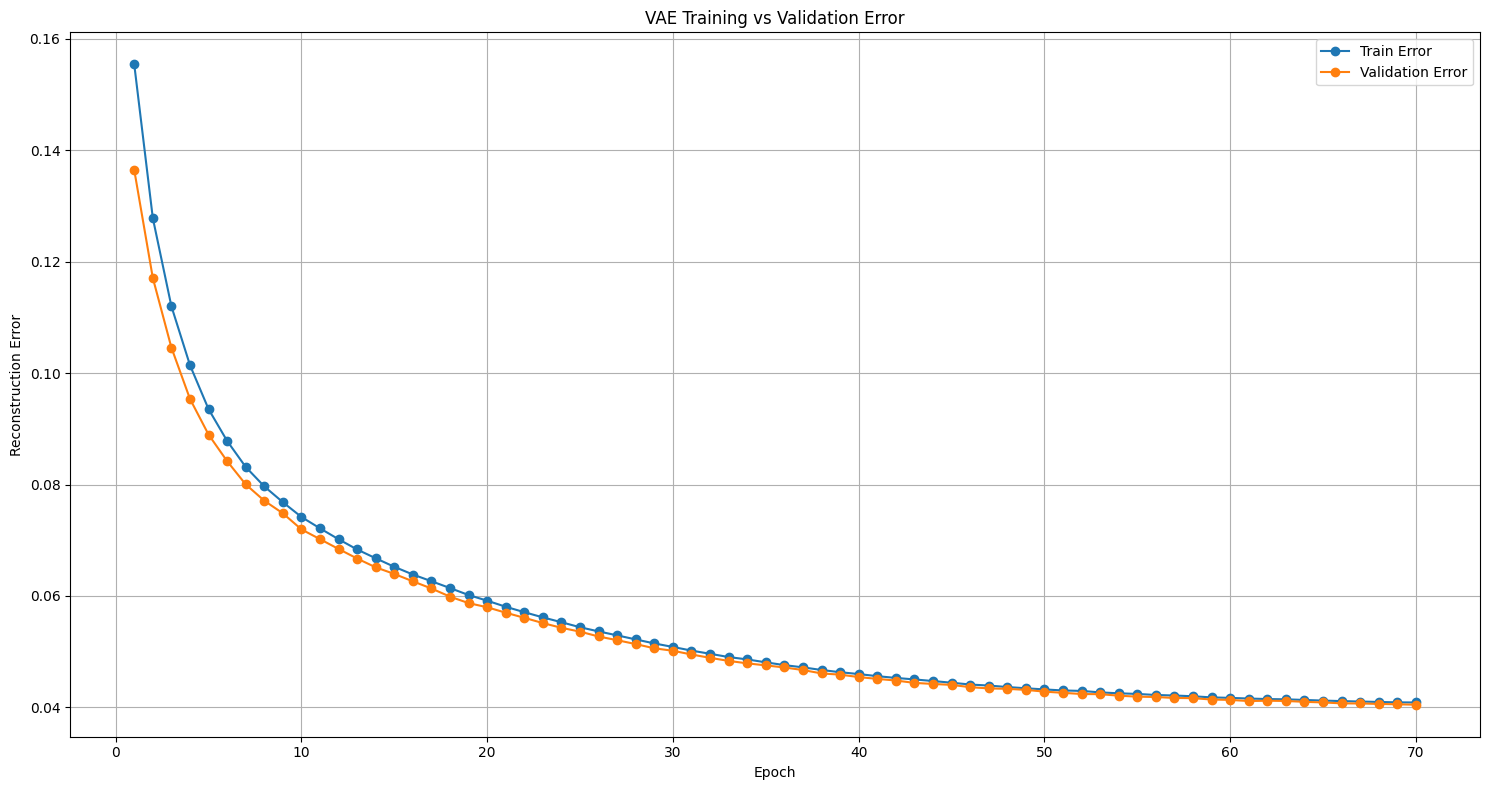

In [ ]:
import matplotlib.pyplot as plt

epochs = list(range(1, 71))
plt.figure(figsize=(15, 8))
plt.plot(epochs, train_errors, label="Train Error", marker='o')
plt.plot(epochs, val_errors, label="Validation Error", marker='o')
plt.xlabel("Epoch")
plt.ylabel("Reconstruction Error")
plt.title("VAE Training vs Validation Error")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

From the plot above,
* it seems that epoch 70 was good enough to avoid overfitting the VAE model
* beyond epoch 70, the reconstruction error would plateau and overfit -> so epoch 70 was just nice
* the reconstruction errors for training and validation set were tracking or closely aligned across epochs

## Load Best VAE

In [ ]:
vae.load_state_dict(best_state_dict)
vae.eval()

VAE(
  (encoder): Sequential(
    (0): Linear(in_features=768, out_features=256, bias=True)
    (1): ReLU()
  )
  (fc_mu): Linear(in_features=256, out_features=64, bias=True)
  (fc_logvar): Linear(in_features=256, out_features=64, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=64, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=768, bias=True)
  )
)

## Choose Optimal Threshold to Classify OOS
* Understand the distribution of val_error


In [ ]:
# val_error is a PyTorch tensor containing the mean reconstruction error for each sample in the validation dataset.
# Each value in the tensor represents the reconstruction error for one validation example.
with torch.no_grad():
    recon_val, _, _ = vae(X_val)
    val_error = F.mse_loss(recon_val, X_val, reduction='none').mean(dim=1)


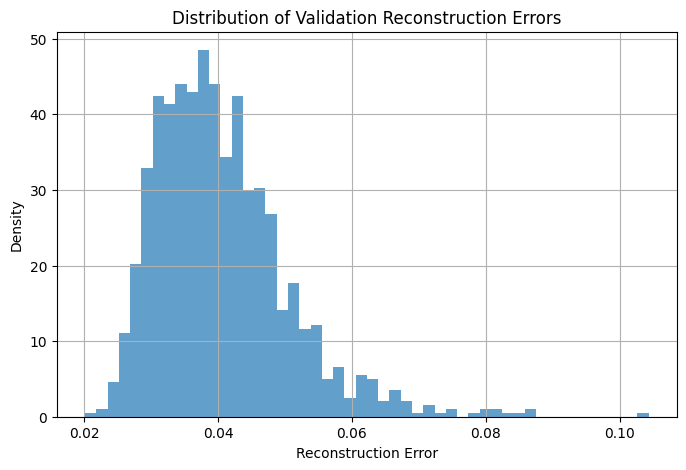

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.hist(val_error.cpu().numpy(), bins=50, density=True, alpha=0.7)
plt.xlabel("Reconstruction Error")
plt.ylabel("Density")
plt.title("Distribution of Validation Reconstruction Errors")
plt.grid(True)
plt.show()

Validation reconstruction error distribution
* The distribution is normally distributed, with a right tail/skew
  * We infer that most examples in the dataset have a low reconstruction error because they were learned by the VAE to reconstruct them very well
  * The examples on the right after around `reconstruction error = 0.05` probably seem to be in the 'OOS'/'Open' intent class, which the model did not learn how to reconstruct
* **Decision from the analysis above: Use the 90th percentile of validation loss/error as a threshold, with the understanding that OOS classes have a high reconstruction error, and therefore a high validation loss/error**
  * Instead of an arbitrary '0.05' threshold, which can vary across datasets
  * Setting the threshold to recognise any input example sentences as 'OOS' with a reconstruction error above the 90th percentile, allows the threshold to be dynamically picked up for each dataset

In [ ]:
threshold = torch.quantile(val_error, 0.7).item()
print(f"Anomaly threshold set at: {threshold:.4f} (70th percentile)")

Anomaly threshold set at: 0.0441 (70th percentile)


In [ ]:
threshold = torch.quantile(val_error, 0.75).item()
print(f"Anomaly threshold set at: {threshold:.4f} (75th percentile)")

Anomaly threshold set at: 0.0456 (75th percentile)


In [ ]:
threshold = torch.quantile(val_error, 0.8).item()
print(f"Anomaly threshold set at: {threshold:.4f} (80th percentile)")

Anomaly threshold set at: 0.0473 (80th percentile)


In [ ]:
threshold = torch.quantile(val_error, 0.85).item()
print(f"Anomaly threshold set at: {threshold:.4f} (85th percentile)")

Anomaly threshold set at: 0.0495 (85th percentile)


In [ ]:
# FROM THE TENSOR OF VALIDATION ERRORS
# Use WHAT IS at THE 90 percentile

threshold = torch.quantile(val_error, 0.9).item()
print(f"Anomaly threshold set at: {threshold:.4f} (90th percentile)")

Anomaly threshold set at: 0.0527 (90th percentile)


In [ ]:
threshold = torch.quantile(val_error, 0.95).item()
print(f"Anomaly threshold set at: {threshold:.4f} (95th percentile)")

Anomaly threshold set at: 0.0588 (95th percentile)


## Test set - Classify known vs open intent
* Setting the 90th percentile validation set reconstruction error as the threshold
* Now we evaluate VAE's performance on an unseen test set

In [ ]:
# from test set, generate embeddings
test_dataset = new_dataset["test"]
test_mean_pooled = get_bert_embedding(classifier_model.bert, tokenizer, test_dataset["text"], DEVICE)

In [ ]:
test_mean_pooled.shape

torch.Size([3080, 768])

In [ ]:
predicted_labels = [] # -1 if open, 1 if known

In [ ]:
test_mean_pooled = test_mean_pooled.to(DEVICE)

with torch.no_grad():
    # from test set embeddings, generate reconstructed output
    recon_new, _, _ = vae(test_mean_pooled)
    # calculate reconstruction loss
    error_new = F.mse_loss(recon_new, test_mean_pooled, reduction='none').mean(dim=1)

    is_anomaly = error_new > threshold
    for err, flag in zip(error_new.cpu(), is_anomaly.cpu()):
        if flag:
            print(f"Predicted anomaly with error {err:.4f}")
            predicted_labels.append(-1)  # -1 = anomaly/OOS/Open intent
        else:
            predicted_labels.append(1)   #  1 = normal/Known intent

Predicted anomaly with error 0.0595
Predicted anomaly with error 0.0624
Predicted anomaly with error 0.0604
Predicted anomaly with error 0.0603
Predicted anomaly with error 0.0691
Predicted anomaly with error 0.0645
Predicted anomaly with error 0.0705
Predicted anomaly with error 0.0596
Predicted anomaly with error 0.0608
Predicted anomaly with error 0.0626
Predicted anomaly with error 0.0630
Predicted anomaly with error 0.0886
Predicted anomaly with error 0.0589
Predicted anomaly with error 0.0642
Predicted anomaly with error 0.0592
Predicted anomaly with error 0.0634
Predicted anomaly with error 0.0665
Predicted anomaly with error 0.0657
Predicted anomaly with error 0.0894
Predicted anomaly with error 0.0603
Predicted anomaly with error 0.0700
Predicted anomaly with error 0.0704
Predicted anomaly with error 0.0618
Predicted anomaly with error 0.0903
Predicted anomaly with error 0.0776
Predicted anomaly with error 0.0628
Predicted anomaly with error 0.0615
Predicted anomaly with error

In [ ]:
# Now convert original label/class to -1/1 to use in calculating F1-score later
# -1 = anomaly/OOS/Open intent
#  1 = normal/Known intent
real_label = [x if x == -1 else 1 for x in test_dataset["label"]]

In [ ]:
# Known intent/class F1 score
print(f"General f1 score is {f1_score(real_label, predicted_labels) * 100}")

General f1 score is 84.07619047619048


In [ ]:
from sklearn.metrics import classification_report
print("Banking, 25% curated OOS/Open intent")
print(classification_report(real_label, predicted_labels, labels=[1, -1], target_names=["Known", "Open"]))

Banking, 25% curated OOS/Open intent
              precision    recall  f1-score   support

       Known       0.75      0.95      0.84      2320
        Open       0.25      0.05      0.08       760

    accuracy                           0.73      3080
   macro avg       0.50      0.50      0.46      3080
weighted avg       0.63      0.73      0.65      3080



In [ ]:
# Save the best VAE model state dict
os.makedirs(MODEL_DIR_VAE, exist_ok=True)
vae_save_path = os.path.join(MODEL_DIR_VAE, "vae_best_state_dict.pt")
torch.save(best_state_dict, vae_save_path)
print(f"Saved best VAE model state dictionary to {vae_save_path}")

Saved best VAE model state dictionary to ./trainvae_banking77/vae_best_state_dict.pt


# Step 3 (1) Generate Embeddings for Full Dataset, (2) Predict Labels, (3) store Embeddings-Sentence-Label combinations, (4) then extract 5 nearest examples for few-shot prompt

## Load Pretrained BERT Tokenizer and Finetuned BERT Model

In [ ]:
from huggingface_hub import hf_hub_download
from transformers import BertTokenizerFast, BertModel
import torch
import os

# Define the Hugging Face repository ID
repo_id = "KaiquanMah/BERT-Banking77-OpenIntentClassification"

# Load the tokenizer
# uses
#   tokenizer.json
#   vocab.txt
#   special_tokens_map.json (defines special tokens like [CLS], [SEP], [PAD])
tokenizer = BertTokenizerFast.from_pretrained(repo_id)
print("Tokenizer loaded successfully.")


# Load the BERT model (this loads the model weights from model.safetensors and config.json)
# uses
#   config.json
#   model.safetensors - after finetuning
bert_model = BertModel.from_pretrained(repo_id)
print("BERT model loaded successfully.")



# To load the classifier state dictionary, you download the classifier.pt file
# then load it into the classifier model instance
classifier_state_dict_path = hf_hub_download(repo_id=repo_id, filename="classifier.pt")

# Initialise your BertMeanPoolClassifier
# extra information: input dimension (usually bert_model.config.hidden_size) and output dimension (num_labels)
num_labels = dataset["train"].features["label"].num_classes
classifier_model = BertMeanPoolClassifier(PRETRAINED_MODEL_NAME, num_labels).to(DEVICE)
# Load the state dictionary into the classifier part of the model
classifier_model.classifier.load_state_dict(torch.load(classifier_state_dict_path, map_location=DEVICE))
print("Classifier state dictionary loaded successfully.")


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

Tokenizer loaded successfully.


config.json:   0%|          | 0.00/618 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

BERT model loaded successfully.


classifier.pt:   0%|          | 0.00/238k [00:00<?, ?B/s]

Classifier state dictionary loaded successfully.


## Load Trained Variational Autoencoder (VAE)

In [ ]:
from huggingface_hub import hf_hub_download
from transformers import BertTokenizerFast, BertModel
import torch
import os

# Define the Hugging Face repository ID
repo_id = "KaiquanMah/VAE-Banking77-OpenIntentClassification"

# Load the trained VAE state dictionary
vae_state_dict_path = hf_hub_download(repo_id=repo_id, filename="vae_best_state_dict.pt")

# Initialise VAE model
# recall that input_dim is 768 (BERT embedding size), hidden_dim is 256, and latent_dim is 64
vae = VAE(input_dim=768, hidden_dim=256, latent_dim=64).to(DEVICE)

# Load the state dictionary into the VAE model
vae.load_state_dict(torch.load(vae_state_dict_path, map_location=DEVICE))
vae.eval() # Set the model to evaluation mode

print("VAE model initialized and state dictionary loaded successfully.")


vae_best_state_dict.pt:   0%|          | 0.00/1.78M [00:00<?, ?B/s]

VAE model initialized and state dictionary loaded successfully.


## Pull AND prepare full THUIAR train+dev+test Banking77 dataset TSV
* to sync up with the same row indexes / sorting order used by the fewshot prompt technique later

In [ ]:
!git clone https://github.com/thuiar/Adaptive-Decision-Boundary.git

Cloning into 'Adaptive-Decision-Boundary'...
remote: Enumerating objects: 211, done.
remote: Counting objects: 100% (38/38), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 211 (delta 36), reused 36 (delta 36), pack-reused 173 (from 1)
Receiving objects: 100% (211/211), 1.26 MiB | 4.64 MiB/s, done.
Resolving deltas: 100% (116/116), done.


In [ ]:
import glob
import os
import pandas as pd

# Initialize an empty DataFrame to store the combined data
main_df = pd.DataFrame()

# Directory containing the banking TSV files
# colab
banking_data_dir = "/content/Adaptive-Decision-Boundary/data/banking"
# # kaggle
# banking_data_dir = "/kaggle/working/Adaptive-Decision-Boundary/data/banking"



# Define the desired order of files
file_order = ["train.tsv", "dev.tsv", "test.tsv"]

# Iterate through the files in the specified order
for file_name in file_order:
    file_path = os.path.join(banking_data_dir, file_name)
    if os.path.exists(file_path):
        # Extract the split name from the filename (e.g., "train", "dev", "test")
        split = os.path.splitext(os.path.basename(file_path))[0]

        # Read the TSV file into a pandas DataFrame
        df = pd.read_csv(file_path, sep='\t')

        # Add a 'split' column to the DataFrame
        df['split'] = split

        # Concatenate the current DataFrame with the main DataFrame
        main_df = pd.concat([main_df, df], ignore_index=True)
    else:
        print(f"Warning: File not found at {file_path}")


# Reset the index of the main DataFrame
main_df = main_df.reset_index(drop=True)

print("Combined DataFrame created successfully.")
display(main_df.head())

# main_df - sort order is now in sync with zeroshot and fewshot prompt technique
#    to sanity check 1st few records, please check results_llama3.2:3b_banking_0_2500.json from
#    https://www.kaggle.com/code/kaiquanmah/01j1-openintent-ollama-llama3-2-3b-bk77-5eg-class/output?scriptVersionId=245719666&select=results_llama3.2%3A3b_banking_0_2500.json

Combined DataFrame created successfully.


,text,label,split
0,Could you help my figure out the exchange fee?,exchange_charge,train
1,I made a cash deposit to my account but i don'...,balance_not_updated_after_cheque_or_cash_deposit,train
2,Hello - I'm on the app and trying to purchase ...,beneficiary_not_allowed,train
3,Why is it saying I have a pending payment?,pending_card_payment,train
4,Is there an extra charge to exchange different...,exchange_charge,train


In [ ]:
main_df["split"].value_counts()

,count
split,
train,9003
test,3080
dev,1000


In [ ]:
# create Dataset from dataframe (of concated TSVs)
from torch.utils.data import Dataset, DataLoader

class BankingDataset(Dataset):
    def __init__(self, df, tokenizer):
        self.texts = df['text'].tolist()
        self.labels = df['label'].values
        self.splits = df['split'].tolist()
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            padding='max_length',
            truncation=True,
            max_length=128,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'text': self.texts[idx],
            'label': self.labels[idx],
            'split': self.splits[idx]
        }

# Create dataset and dataloader
full_dataset = BankingDataset(main_df, tokenizer)
dataloader = DataLoader(full_dataset, batch_size=64, shuffle=False)

## Generate Embeddings and Predictions

In [ ]:
import torch
from tqdm import tqdm

vae_p90_threshold = 0.0527 # from VAE training

results = {
    'text': [],
    'label': [],
    'split': [],
    'embedding': [],
    'recon_error': [],
    'prediction': []  # 1 = known, -1 = open
}

classifier_model.eval()
vae.eval()

with torch.no_grad():
    for batch in tqdm(dataloader):
        # Move to device
        input_ids = batch['input_ids'].to(DEVICE)
        attention_mask = batch['attention_mask'].to(DEVICE)

        # Get BERT embeddings
        outputs = classifier_model.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        last_hidden = outputs.last_hidden_state
        mask = attention_mask.unsqueeze(-1).float()
        summed = torch.sum(last_hidden * mask, dim=1)
        counts = torch.clamp(mask.sum(dim=1), min=1e-9)
        embeddings = summed / counts

        # Get VAE predictions
        recon, mu, logvar = vae(embeddings)
        errors = F.mse_loss(recon, embeddings, reduction='none').mean(dim=1)
        predictions = torch.where(errors > vae_p90_threshold, -1, 1)  # -1 = open, 1 = known

        # Store results
        results['text'].extend(batch['text'])
        results['label'].extend(batch['label'])
        results['split'].extend(batch['split'])
        results['embedding'].extend(embeddings.cpu().numpy())
        results['recon_error'].extend(errors.cpu().numpy())
        results['prediction'].extend(predictions.cpu().numpy())

# Convert to DataFrame
results_df = pd.DataFrame(results)

100%|██████████| 205/205 [01:38<00:00,  2.08it/s]


In [ ]:
results_df

,text,label,split,embedding,recon_error,prediction
0,Could you help my figure out the exchange fee?,exchange_charge,train,"[0.16440804, -0.4486033, 0.19658549, 0.0599304...",0.044956,1
1,I made a cash deposit to my account but i don'...,balance_not_updated_after_cheque_or_cash_deposit,train,"[0.28175536, 0.08327638, 0.24815111, -0.069128...",0.030881,1
2,Hello - I'm on the app and trying to purchase ...,beneficiary_not_allowed,train,"[0.37068483, 0.08766311, 0.23449095, -0.093238...",0.036947,1
3,Why is it saying I have a pending payment?,pending_card_payment,train,"[0.18455218, 0.22712159, 0.23453903, 0.0216699...",0.025199,1
4,Is there an extra charge to exchange different...,exchange_charge,train,"[0.08268758, -0.5402498, -0.004048739, 0.31251...",0.048094,1
...,...,...,...,...,...,...
13078,I cannot locate the verification code for my t...,verify_top_up,test,"[0.13051839, 0.19814493, 0.21461421, -0.049604...",0.034365,1
13079,If I make a top-up are there charges applied?,top_up_by_bank_transfer_charge,test,"[0.15917169, -0.32904127, 0.43831912, -0.04485...",0.033965,1
13080,What is the minimum age?,age_limit,test,"[0.14351729, -0.0028254353, -0.07564013, -0.24...",0.058217,-1
13081,Is there a reason why my transaction is taking...,transfer_not_received_by_recipient,test,"[-0.017121043, -0.19843367, 0.030960236, -0.18...",0.033706,1


In [ ]:
# export to CSV with row index,
# to make it easier to trace to the fewshot example files we create later for each input qn/sentence on each row
results_df.to_csv('banking77_w_bert_embeddings_n_vae_predictions.csv', index=True, index_label="tsvidx")

## Create FAISS Index with Cosine Similarity
* FAISS (Facebook AI Similarity Search) library is designed for fast similarity search and clustering of dense vectors
* IndexFlatIP from FAISS allows the use of cosine similarity/Inner Product (IP) as the similarity metric, to find the nearest neighbour examples in high-dimensional spaces
* To read more about FAISS index techniques, please visit https://github.com/facebookresearch/faiss/wiki/Faiss-indexes


### Install and Troubleshoot FAISS

In [ ]:
# import faiss
# import numpy as np

# # Normalize embeddings for cosine similarity
# embeddings = np.array(results_df['embedding'].tolist()).astype('float32')
# faiss.normalize_L2(embeddings)  # Essential for cosine similarity

# # Create FAISS index
# index = faiss.IndexFlatIP(embeddings.shape[1])  # Inner product = cosine when normalized
# index.add(embeddings)

# # Save index and metadata
# faiss.write_index(index, "banking77_cosine_index.faiss")
# results_df.drop(columns=['embedding']).to_parquet("banking77_metadata.parquet")

In [ ]:
# check python version
import sys
print(sys.version)

3.11.13 (main, Jun  4 2025, 08:57:29) [GCC 11.4.0]


In [ ]:
import torch
print(torch.version.cuda)

12.4


In [ ]:
!nvidia-smi

Tue Aug 12 03:42:21 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-PCIE-16GB           Off |   00000000:00:04.0 Off |                    0 |
| N/A   49C    P0             37W /  250W |    2009MiB /  16384MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [ ]:
import platform
import sys

print(f"Operating System: {platform.system()} {platform.release()}")
print(f"System Architecture: {platform.machine()}")
print(f"Python Version: {sys.version}")
print(f"Python Bitness: {64 if sys.maxsize > 2**32 else 32}-bit")

Operating System: Linux 6.6.56+
System Architecture: x86_64
Python Version: 3.11.13 (main, Jun  4 2025, 08:57:29) [GCC 11.4.0]
Python Bitness: 64-bit


In [ ]:
# !pip install --upgrade pip
!python3.11 -m pip install --upgrade pip

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 18.7 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2


In [ ]:
# Install FAISS to use its vector store

# ERROR: Could not find a version that satisfies the requirement faiss (from versions: none)
# ERROR: No matching distribution found for faiss
# !pip install faiss

# https://github.com/facebookresearch/faiss/blob/main/INSTALL.md
# !conda install faiss-gpu

# https://stackoverflow.com/questions/47967252/installing-faiss-on-google-colaboratory
# !apt install -y libomp-dev
# !python -m pip install --upgrade faiss-cpu faiss-gpu
# !pip uninstall -y faiss faiss-gpu faiss-cpu
# !pip install --upgrade --no-cache-dir faiss-gpu==1.7.4 -f https://faiss-assets.s3.amazonaws.com/whl/cu118/

# ERROR: Could not find a version that satisfies the requirement faiss-gpu (from versions: none)
# ERROR: No matching distribution found for faiss-gpu
# !pip install faiss-cpu faiss-gpu
# !pip install faiss-gpu-cu12
# !pip install faiss-cpu faiss-gpu-cu12

# installation that works
# !python3.11 -m pip install --no-cache-dir faiss-cpu faiss-gpu-cu12
!python3.11 -m pip install --no-cache-dir faiss-gpu-cu12

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.0/48.0 MB 229.7 MB/s  0:00:00


In [ ]:
# sanity check installation
import faiss
print(faiss.__version__)

# This will print the number of NVIDIA GPUs that Faiss can see.
# A successful installation should print 1 or more.
# If it prints 0, it means Faiss is running in CPU-only mode.
print(f"Faiss has access to {faiss.get_num_gpus()} GPUs.")

1.11.0
Faiss has access to 1 GPUs.


### Create FAISS Index

In [ ]:
import faiss

# Generate normalized embeddings for cosine similarity
embeddings_array = np.array(results_df['embedding'].tolist()).astype('float32')
faiss.normalize_L2(embeddings_array)  # Crucial for cosine similarity

# Create FAISS index
index = faiss.IndexFlatIP(embeddings_array.shape[1])  # Inner product = cosine similarity
index.add(embeddings_array)

# Save index for future use
faiss.write_index(index, "banking77_cosine_index.faiss")
print("FAISS index created for cosine similarity")

FAISS index created for cosine similarity


## Cosine Similarity Retrieval Functions

In [ ]:
# if we want to read from a previously generated FAISS Index
import faiss

# Read the FAISS index from the file
index = faiss.read_index("banking77_cosine_index.faiss")
print("FAISS index loaded successfully.")

FAISS index loaded successfully.


In [ ]:
import random
import pandas as pd
import numpy as np
import json
from tqdm import tqdm

# Map label indices to human-readable category names
intent_names = dataset['train'].features['label'].names

# Create output directory
os.makedirs("few_shot_examples", exist_ok=True)


def format_example(k: int, text: str, label: str) -> str:
    """Format a single example in the required structure"""
    # Find the integer index of the label string in the intent_names list
    label_index = intent_names.index(label)
    category = intent_names[label_index]
    confidence = round(random.uniform(0.0, 100.0), 2)  # Random confidence
    return (
        f"Example {k}:\n"
        f'Question: "{text}"\n'
        f"Category:\n"
        f"{{\n"
        f'  "category": "{category}",\n'
        f'  "confidence": {confidence}\n'
        f"}}"
    )

def get_nearest_examples(query_idx: int, k: int = 5) -> str:
    """Retrieve and format k nearest neighbors excluding self"""
    # Get query embedding
    query_embed = embeddings_array[query_idx].reshape(1, -1).astype('float32')

    # Search FAISS index (k+1 to get '1 more sentence', to exclude the input sentence/self later)
    distances, indices = index.search(query_embed, k+1)

    # Filter out input sentence/self-reference
    neighbor_indices = indices[0][indices[0] != query_idx][:k]

    # Format each example
    examples = []
    for i, idx in enumerate(neighbor_indices, 1):
        text = main_df.iloc[idx]['text']
        label = main_df.iloc[idx]['label']
        examples.append(format_example(i, text, label))

    return "\n\n".join(examples)

## Generate and Store 5 Nearest Examples

In [ ]:
# Initialize list for parquet storage
parquet_data = []


# create 1 fewshot file for each input sentence/qn
for idx in tqdm(range(len(main_df)), desc="Generating 5-shot examples"):
    # Generate the 5-shot examples string
    examples_str = get_nearest_examples(idx)

    # Save individual example file
    with open(f"few_shot_examples/{idx}.txt", "w") as f:
        f.write(examples_str)


    # Create metadata record
    record = {
        "text": main_df.iloc[idx]['text'],
        "label": main_df.iloc[idx]['label'],
        "split": main_df.iloc[idx]['split'],
        "examples": examples_str
    }

    # Add to parquet storage later
    parquet_data.append(record)


# create master parquet file
few_shot_df = pd.DataFrame(parquet_data)
few_shot_df.to_parquet("banking77_few_shot_examples.parquet")

Generating 5-shot examples: 100%|██████████| 13083/13083 [01:08<00:00, 191.64it/s]


In [ ]:
few_shot_df

,text,label,split,examples
0,Could you help my figure out the exchange fee?,exchange_charge,train,"Example 1:\nQuestion: ""Can you tell me about t..."
1,I made a cash deposit to my account but i don'...,balance_not_updated_after_cheque_or_cash_deposit,train,"Example 1:\nQuestion: ""I placed a cash deposit..."
2,Hello - I'm on the app and trying to purchase ...,beneficiary_not_allowed,train,"Example 1:\nQuestion: ""I'm trying to purchase ..."
3,Why is it saying I have a pending payment?,pending_card_payment,train,"Example 1:\nQuestion: ""why do I have a pending..."
4,Is there an extra charge to exchange different...,exchange_charge,train,"Example 1:\nQuestion: ""Is there an additional ..."
...,...,...,...,...
13078,I cannot locate the verification code for my t...,verify_top_up,test,"Example 1:\nQuestion: ""I need help finding the..."
13079,If I make a top-up are there charges applied?,top_up_by_bank_transfer_charge,test,"Example 1:\nQuestion: ""Am I charged if I make ..."
13080,What is the minimum age?,age_limit,test,"Example 1:\nQuestion: ""What is the minimum age..."
13081,Is there a reason why my transaction is taking...,transfer_not_received_by_recipient,test,"Example 1:\nQuestion: ""Why is my transaction t..."


In [ ]:
few_shot_df.loc[0, "examples"]

'Example 1:\nQuestion: "Can you tell me about the exchange fee?"\nCategory:\n{\n  "category": "exchange_charge",\n  "confidence": 63.94\n}\n\nExample 2:\nQuestion: "Can you explain the transfer fee to me?"\nCategory:\n{\n  "category": "transfer_fee_charged",\n  "confidence": 2.5\n}\n\nExample 3:\nQuestion: "Can you tell me what the exchange fee is?"\nCategory:\n{\n  "category": "exchange_charge",\n  "confidence": 27.5\n}\n\nExample 4:\nQuestion: "Can you help me process a refund?"\nCategory:\n{\n  "category": "request_refund",\n  "confidence": 22.32\n}\n\nExample 5:\nQuestion: "Can you help me track my card?"\nCategory:\n{\n  "category": "card_arrival",\n  "confidence": 73.65\n}'

In [ ]:
print(few_shot_df.loc[0, "examples"])

Example 1:
Question: "Can you tell me about the exchange fee?"
Category:
{
  "category": "exchange_charge",
  "confidence": 63.94
}

Example 2:
Question: "Can you explain the transfer fee to me?"
Category:
{
  "category": "transfer_fee_charged",
  "confidence": 2.5
}

Example 3:
Question: "Can you tell me what the exchange fee is?"
Category:
{
  "category": "exchange_charge",
  "confidence": 27.5
}

Example 4:
Question: "Can you help me process a refund?"
Category:
{
  "category": "request_refund",
  "confidence": 22.32
}

Example 5:
Question: "Can you help me track my card?"
Category:
{
  "category": "card_arrival",
  "confidence": 73.65
}


In [ ]:
few_shot_df.to_csv("banking77_5_nearest_few_shot_examples.csv", index=True, index_label="tsvidx")

In [ ]:
# sanity check count of txt files in 'few_shot_examples' directory
# because previously there was some unexpected issue in run 1 - only 31 files were generated

import os

few_shot_dir = "few_shot_examples"
if os.path.exists(few_shot_dir):
    files_in_dir = os.listdir(few_shot_dir)
    print(f"Number of files in '{few_shot_dir}': {len(files_in_dir)}")
    # Optionally, print the first few filenames to verify
    # print("First 10 filenames:", files_in_dir[:10])
else:
    print(f"Directory '{few_shot_dir}' does not exist.")

Number of files in 'few_shot_examples': 13083


In [ ]:
# zip few_shot_examples .txt files into 1 .zip for easy download later
!zip -r few_shot_examples.zip few_shot_examples/

  adding: few_shot_examples/ (stored 0%)
  adding: few_shot_examples/9500.txt (deflated 66%)
  adding: few_shot_examples/3973.txt (deflated 62%)
  adding: few_shot_examples/2059.txt (deflated 67%)
  adding: few_shot_examples/1715.txt (deflated 75%)
  adding: few_shot_examples/3783.txt (deflated 58%)
  adding: few_shot_examples/8066.txt (deflated 71%)
  adding: few_shot_examples/11908.txt (deflated 58%)
  adding: few_shot_examples/11196.txt (deflated 69%)
  adding: few_shot_examples/10749.txt (deflated 69%)
  adding: few_shot_examples/1893.txt (deflated 64%)
  adding: few_shot_examples/911.txt (deflated 68%)
  adding: few_shot_examples/12557.txt (deflated 70%)
  adding: few_shot_examples/6904.txt (deflated 71%)
  adding: few_shot_examples/5986.txt (deflated 68%)
  adding: few_shot_examples/9498.txt (deflated 71%)
  adding: few_shot_examples/11234.txt (deflated 55%)
  adding: few_shot_examples/3917.txt (deflated 63%)
  adding: few_shot_examples/11227.txt (deflated 70%)
  adding: few_shot

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


 (deflated 61%)
  adding: few_shot_examples/11676.txt (deflated 58%)
  adding: few_shot_examples/5232.txt (deflated 56%)
  adding: few_shot_examples/6843.txt (deflated 71%)
  adding: few_shot_examples/2731.txt (deflated 65%)
  adding: few_shot_examples/5074.txt (deflated 68%)
  adding: few_shot_examples/713.txt (deflated 65%)
  adding: few_shot_examples/9611.txt (deflated 65%)
  adding: few_shot_examples/11138.txt (deflated 55%)
  adding: few_shot_examples/2312.txt (deflated 61%)
  adding: few_shot_examples/9879.txt (deflated 71%)
  adding: few_shot_examples/9071.txt (deflated 55%)
  adding: few_shot_examples/4062.txt (deflated 63%)
  adding: few_shot_examples/12458.txt (deflated 69%)
  adding: few_shot_examples/9738.txt (deflated 67%)
  adding: few_shot_examples/2420.txt (deflated 59%)
  adding: few_shot_examples/8291.txt (deflated 67%)
  adding: few_shot_examples/8126.txt (deflated 64%)
  adding: few_shot_examples/11020.txt (deflated 65%)
  adding: few_shot_examples/11750.txt (deflat

# Step 4 Identify Question Sentences to Input to Fewshot Method

## Load Saved Embeddings, Fewshot Examples

In [ ]:
from huggingface_hub import snapshot_download

# Define the Hugging Face repository ID
repo_id = "KaiquanMah/VAE-Banking77-OpenIntentClassification"

snapshot_path = snapshot_download(
    repo_id=repo_id,
    allow_patterns=["*.json", "*.faiss", "*.csv", "*.parquet", "*.zip"],
    local_dir=".", # download to the current working dir
)
print(f"Snapshot downloaded to: {snapshot_path}")


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

banking77_few_shot_examples.parquet:   0%|          | 0.00/3.52M [00:00<?, ?B/s]

Snapshot downloaded to: /content


## Load full THUIAR train+dev+test Banking77 dataset TSV
* to sanity check rows have the same row indexes / sorting order used by the fewshot prompt technique later

In [ ]:
!git clone https://github.com/thuiar/Adaptive-Decision-Boundary.git

Cloning into 'Adaptive-Decision-Boundary'...
remote: Enumerating objects: 211, done.
remote: Counting objects: 100% (38/38), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 211 (delta 36), reused 36 (delta 36), pack-reused 173 (from 1)
Receiving objects: 100% (211/211), 1.26 MiB | 4.43 MiB/s, done.
Resolving deltas: 100% (116/116), done.


In [ ]:
import glob
import os
import pandas as pd

# Initialize an empty DataFrame to store the combined data
main_df = pd.DataFrame()

# Directory containing the banking TSV files
# colab
banking_data_dir = "/content/Adaptive-Decision-Boundary/data/banking"
# # kaggle
# banking_data_dir = "/kaggle/working/Adaptive-Decision-Boundary/data/banking"



# Define the desired order of files
file_order = ["train.tsv", "dev.tsv", "test.tsv"]

# Iterate through the files in the specified order
for file_name in file_order:
    file_path = os.path.join(banking_data_dir, file_name)
    if os.path.exists(file_path):
        # Extract the split name from the filename (e.g., "train", "dev", "test")
        split = os.path.splitext(os.path.basename(file_path))[0]

        # Read the TSV file into a pandas DataFrame
        df = pd.read_csv(file_path, sep='\t')

        # Add a 'split' column to the DataFrame
        df['split'] = split

        # Concatenate the current DataFrame with the main DataFrame
        main_df = pd.concat([main_df, df], ignore_index=True)
    else:
        print(f"Warning: File not found at {file_path}")


# Reset the index of the main DataFrame
main_df = main_df.reset_index(drop=True)

print("Combined DataFrame created successfully.")
display(main_df.head())

# main_df - sort order is now in sync with zeroshot and fewshot prompt technique
#    to sanity check 1st few records, please check results_llama3.2:3b_banking_0_2500.json from
#    https://www.kaggle.com/code/kaiquanmah/01j1-openintent-ollama-llama3-2-3b-bk77-5eg-class/output?scriptVersionId=245719666&select=results_llama3.2%3A3b_banking_0_2500.json

Combined DataFrame created successfully.


,text,label,split
0,Could you help my figure out the exchange fee?,exchange_charge,train
1,I made a cash deposit to my account but i don'...,balance_not_updated_after_cheque_or_cash_deposit,train
2,Hello - I'm on the app and trying to purchase ...,beneficiary_not_allowed,train
3,Why is it saying I have a pending payment?,pending_card_payment,train
4,Is there an extra charge to exchange different...,exchange_charge,train


## Analse Embeddings, Fewshot Examples
* Note that
  * embeddings and vae predictions are in `banking77_w_bert_embeddings_n_vae_predictions.csv`
  * we have few shot examples in
    * `banking77_5_nearest_few_shot_examples.csv`
    * `banking77_few_shot_examples.parquet` (same 5 bearest fewshot examples; much smaller file size than CSV)
    * `few_shot_examples.zip`
      * `<row_index_num>.txt` - 1 txt per row ((same 5 bearest fewshot examples)
  * with the variety of ways you can use the fewshot examples - CSV, parquet, zip of txt files, you can choose the way that works best for you
  * for our use case, we will go with parquet to read the dataset into the fewshot prompt pipeline later, because 1 df is easy to work with, and the small file size can hopefully speed up processing time

### [OK] sanity check sort order between THUIAR vs "embeddings n vae predictions" df
* sort order same
* vae predicted classes
  * known	11699
  * open	1384


In [ ]:
df_embeddings_n_predictions = pd.read_csv('/content/banking77_w_bert_embeddings_n_vae_predictions.csv')
df_embeddings_n_predictions

,tsvidx,text,label,split,embedding,recon_error,prediction
0,0,Could you help my figure out the exchange fee?,exchange_charge,train,[ 1.64408043e-01 -4.48603302e-01 1.96585491e-...,0.044956,1
1,1,I made a cash deposit to my account but i don'...,balance_not_updated_after_cheque_or_cash_deposit,train,[ 2.81755358e-01 8.32763836e-02 2.48151109e-...,0.030881,1
2,2,Hello - I'm on the app and trying to purchase ...,beneficiary_not_allowed,train,[ 3.70684832e-01 8.76631066e-02 2.34490946e-...,0.036947,1
3,3,Why is it saying I have a pending payment?,pending_card_payment,train,[ 1.84552178e-01 2.27121592e-01 2.34539032e-...,0.025199,1
4,4,Is there an extra charge to exchange different...,exchange_charge,train,[ 8.26875791e-02 -5.40249825e-01 -4.04873909e-...,0.048094,1
...,...,...,...,...,...,...,...
13078,13078,I cannot locate the verification code for my t...,verify_top_up,test,[ 1.30518392e-01 1.98144928e-01 2.14614213e-...,0.034365,1
13079,13079,If I make a top-up are there charges applied?,top_up_by_bank_transfer_charge,test,[ 1.59171686e-01 -3.29041272e-01 4.38319117e-...,0.033965,1
13080,13080,What is the minimum age?,age_limit,test,[ 1.43517286e-01 -2.82543525e-03 -7.56401271e-...,0.058217,-1
13081,13081,Is there a reason why my transaction is taking...,transfer_not_received_by_recipient,test,[-1.71210431e-02 -1.98433667e-01 3.09602357e-...,0.033706,1


In [ ]:
main_df.columns

Index(['text', 'label', 'split'], dtype='object')

In [ ]:
df_embeddings_n_predictions.columns

Index(['tsvidx', 'text', 'label', 'split', 'embedding', 'recon_error',
       'prediction'],
      dtype='object')

In [ ]:
# Concat main_df and df_embeddings_n_predictions
df_thuiar_to_predictions = pd.concat([main_df, df_embeddings_n_predictions],
                                     axis=1)

# specify col names to avoid overlapping colnames
df_thuiar_to_predictions.columns = list(main_df.columns) + \
                                   ['tsvidx', 'pred_text', 'pred_label', 'pred_split', 'embedding', 'recon_error', 'prediction']

# # create the 'vae_class' column
df_thuiar_to_predictions['vae_class'] = df_thuiar_to_predictions['prediction'].apply(lambda x: 'known' if x == 1 else 'open')
df_thuiar_to_predictions['idx_match'] = df_thuiar_to_predictions.text == df_thuiar_to_predictions.pred_text

# df_thuiar_to_predictions

In [ ]:
df_thuiar_to_predictions

,text,label,split,tsvidx,pred_text,pred_label,pred_split,embedding,recon_error,prediction,vae_class,idx_match
0,Could you help my figure out the exchange fee?,exchange_charge,train,0,Could you help my figure out the exchange fee?,exchange_charge,train,[ 1.64408043e-01 -4.48603302e-01 1.96585491e-...,0.044956,1,known,True
1,I made a cash deposit to my account but i don'...,balance_not_updated_after_cheque_or_cash_deposit,train,1,I made a cash deposit to my account but i don'...,balance_not_updated_after_cheque_or_cash_deposit,train,[ 2.81755358e-01 8.32763836e-02 2.48151109e-...,0.030881,1,known,True
2,Hello - I'm on the app and trying to purchase ...,beneficiary_not_allowed,train,2,Hello - I'm on the app and trying to purchase ...,beneficiary_not_allowed,train,[ 3.70684832e-01 8.76631066e-02 2.34490946e-...,0.036947,1,known,True
3,Why is it saying I have a pending payment?,pending_card_payment,train,3,Why is it saying I have a pending payment?,pending_card_payment,train,[ 1.84552178e-01 2.27121592e-01 2.34539032e-...,0.025199,1,known,True
4,Is there an extra charge to exchange different...,exchange_charge,train,4,Is there an extra charge to exchange different...,exchange_charge,train,[ 8.26875791e-02 -5.40249825e-01 -4.04873909e-...,0.048094,1,known,True
...,...,...,...,...,...,...,...,...,...,...,...,...
13078,I cannot locate the verification code for my t...,verify_top_up,test,13078,I cannot locate the verification code for my t...,verify_top_up,test,[ 1.30518392e-01 1.98144928e-01 2.14614213e-...,0.034365,1,known,True
13079,If I make a top-up are there charges applied?,top_up_by_bank_transfer_charge,test,13079,If I make a top-up are there charges applied?,top_up_by_bank_transfer_charge,test,[ 1.59171686e-01 -3.29041272e-01 4.38319117e-...,0.033965,1,known,True
13080,What is the minimum age?,age_limit,test,13080,What is the minimum age?,age_limit,test,[ 1.43517286e-01 -2.82543525e-03 -7.56401271e-...,0.058217,-1,open,True
13081,Is there a reason why my transaction is taking...,transfer_not_received_by_recipient,test,13081,Is there a reason why my transaction is taking...,transfer_not_received_by_recipient,test,[-1.71210431e-02 -1.98433667e-01 3.09602357e-...,0.033706,1,known,True


In [ ]:
df_thuiar_to_predictions.vae_class.value_counts()

,count
vae_class,
known,11699
open,1384


In [ ]:
df_thuiar_to_predictions.idx_match.value_counts()

,count
idx_match,
True,13083


### [OK] sanity check sort order between THUIAR vs "few_shot_examples" df (using csv)
* sort order same


In [ ]:
df_fewshot_csv = pd.read_csv('/content/banking77_5_nearest_few_shot_examples.csv')
df_fewshot_csv

,tsvidx,text,label,split,examples
0,0,Could you help my figure out the exchange fee?,exchange_charge,train,"Example 1:\nQuestion: ""Can you tell me about t..."
1,1,I made a cash deposit to my account but i don'...,balance_not_updated_after_cheque_or_cash_deposit,train,"Example 1:\nQuestion: ""I placed a cash deposit..."
2,2,Hello - I'm on the app and trying to purchase ...,beneficiary_not_allowed,train,"Example 1:\nQuestion: ""I'm trying to purchase ..."
3,3,Why is it saying I have a pending payment?,pending_card_payment,train,"Example 1:\nQuestion: ""why do I have a pending..."
4,4,Is there an extra charge to exchange different...,exchange_charge,train,"Example 1:\nQuestion: ""Is there an additional ..."
...,...,...,...,...,...
13078,13078,I cannot locate the verification code for my t...,verify_top_up,test,"Example 1:\nQuestion: ""I need help finding the..."
13079,13079,If I make a top-up are there charges applied?,top_up_by_bank_transfer_charge,test,"Example 1:\nQuestion: ""Am I charged if I make ..."
13080,13080,What is the minimum age?,age_limit,test,"Example 1:\nQuestion: ""What is the minimum age..."
13081,13081,Is there a reason why my transaction is taking...,transfer_not_received_by_recipient,test,"Example 1:\nQuestion: ""Why is my transaction t..."


In [ ]:
main_df.columns

Index(['text', 'label', 'split'], dtype='object')

In [ ]:
df_fewshot_csv.columns

Index(['tsvidx', 'text', 'label', 'split', 'examples'], dtype='object')

In [ ]:
# Concat main_df and df_fewshot_csv
df_thuiar_to_fewshotcsv = pd.concat([main_df, df_fewshot_csv],
                                     axis=1)

# specify col names to avoid overlapping colnames
df_thuiar_to_fewshotcsv.columns = list(main_df.columns) + \
                                   ['tsvidx', 'fewshot_text', 'fewshot_label', 'fewshot_split', 'examples']

# match row index using the 'text'
df_thuiar_to_fewshotcsv['idx_match'] = df_thuiar_to_fewshotcsv.text == df_thuiar_to_fewshotcsv.fewshot_text


In [ ]:
df_thuiar_to_fewshotcsv

,text,label,split,tsvidx,fewshot_text,fewshot_label,fewshot_split,examples,idx_match
0,Could you help my figure out the exchange fee?,exchange_charge,train,0,Could you help my figure out the exchange fee?,exchange_charge,train,"Example 1:\nQuestion: ""Can you tell me about t...",True
1,I made a cash deposit to my account but i don'...,balance_not_updated_after_cheque_or_cash_deposit,train,1,I made a cash deposit to my account but i don'...,balance_not_updated_after_cheque_or_cash_deposit,train,"Example 1:\nQuestion: ""I placed a cash deposit...",True
2,Hello - I'm on the app and trying to purchase ...,beneficiary_not_allowed,train,2,Hello - I'm on the app and trying to purchase ...,beneficiary_not_allowed,train,"Example 1:\nQuestion: ""I'm trying to purchase ...",True
3,Why is it saying I have a pending payment?,pending_card_payment,train,3,Why is it saying I have a pending payment?,pending_card_payment,train,"Example 1:\nQuestion: ""why do I have a pending...",True
4,Is there an extra charge to exchange different...,exchange_charge,train,4,Is there an extra charge to exchange different...,exchange_charge,train,"Example 1:\nQuestion: ""Is there an additional ...",True
...,...,...,...,...,...,...,...,...,...
13078,I cannot locate the verification code for my t...,verify_top_up,test,13078,I cannot locate the verification code for my t...,verify_top_up,test,"Example 1:\nQuestion: ""I need help finding the...",True
13079,If I make a top-up are there charges applied?,top_up_by_bank_transfer_charge,test,13079,If I make a top-up are there charges applied?,top_up_by_bank_transfer_charge,test,"Example 1:\nQuestion: ""Am I charged if I make ...",True
13080,What is the minimum age?,age_limit,test,13080,What is the minimum age?,age_limit,test,"Example 1:\nQuestion: ""What is the minimum age...",True
13081,Is there a reason why my transaction is taking...,transfer_not_received_by_recipient,test,13081,Is there a reason why my transaction is taking...,transfer_not_received_by_recipient,test,"Example 1:\nQuestion: ""Why is my transaction t...",True


In [ ]:
df_thuiar_to_fewshotcsv.idx_match.value_counts()

,count
idx_match,
True,13083


### [OK] sanity check sort order between THUIAR vs "few_shot_examples" df (using parquet - smaller file)
* sort order same
* 3 examples (2 from top, 1 from bottom) - look ok


In [ ]:
df_fewshot_parquet = pd.read_parquet('/content/banking77_few_shot_examples.parquet')
df_fewshot_parquet = df_fewshot_parquet.reset_index()
df_fewshot_parquet

,tsvidx,text,label,split,examples
0,0,Could you help my figure out the exchange fee?,exchange_charge,train,"Example 1:\nQuestion: ""Can you tell me about t..."
1,1,I made a cash deposit to my account but i don'...,balance_not_updated_after_cheque_or_cash_deposit,train,"Example 1:\nQuestion: ""I placed a cash deposit..."
2,2,Hello - I'm on the app and trying to purchase ...,beneficiary_not_allowed,train,"Example 1:\nQuestion: ""I'm trying to purchase ..."
3,3,Why is it saying I have a pending payment?,pending_card_payment,train,"Example 1:\nQuestion: ""why do I have a pending..."
4,4,Is there an extra charge to exchange different...,exchange_charge,train,"Example 1:\nQuestion: ""Is there an additional ..."
...,...,...,...,...,...
13078,13078,I cannot locate the verification code for my t...,verify_top_up,test,"Example 1:\nQuestion: ""I need help finding the..."
13079,13079,If I make a top-up are there charges applied?,top_up_by_bank_transfer_charge,test,"Example 1:\nQuestion: ""Am I charged if I make ..."
13080,13080,What is the minimum age?,age_limit,test,"Example 1:\nQuestion: ""What is the minimum age..."
13081,13081,Is there a reason why my transaction is taking...,transfer_not_received_by_recipient,test,"Example 1:\nQuestion: ""Why is my transaction t..."


In [ ]:
main_df.columns

Index(['text', 'label', 'split'], dtype='object')

In [ ]:
df_fewshot_parquet.columns

Index(['tsvidx', 'text', 'label', 'split', 'examples'], dtype='object')

In [ ]:
# Concat main_df and df_fewshot_parquet
df_thuiar_to_fewshoteg_parquet = pd.concat([main_df, df_fewshot_parquet],
                                     axis=1)

# specify col names to avoid overlapping colnames
df_thuiar_to_fewshoteg_parquet.columns = list(main_df.columns) + \
                                         ['tsvidx', 'fewshot_text', 'fewshot_label', 'fewshot_split', 'examples']

# match row index using the 'text'
df_thuiar_to_fewshoteg_parquet['idx_match'] = df_thuiar_to_fewshoteg_parquet.text == df_thuiar_to_fewshoteg_parquet.fewshot_text


In [ ]:
df_thuiar_to_fewshoteg_parquet

,text,label,split,tsvidx,fewshot_text,fewshot_label,fewshot_split,examples,idx_match
0,Could you help my figure out the exchange fee?,exchange_charge,train,0,Could you help my figure out the exchange fee?,exchange_charge,train,"Example 1:\nQuestion: ""Can you tell me about t...",True
1,I made a cash deposit to my account but i don'...,balance_not_updated_after_cheque_or_cash_deposit,train,1,I made a cash deposit to my account but i don'...,balance_not_updated_after_cheque_or_cash_deposit,train,"Example 1:\nQuestion: ""I placed a cash deposit...",True
2,Hello - I'm on the app and trying to purchase ...,beneficiary_not_allowed,train,2,Hello - I'm on the app and trying to purchase ...,beneficiary_not_allowed,train,"Example 1:\nQuestion: ""I'm trying to purchase ...",True
3,Why is it saying I have a pending payment?,pending_card_payment,train,3,Why is it saying I have a pending payment?,pending_card_payment,train,"Example 1:\nQuestion: ""why do I have a pending...",True
4,Is there an extra charge to exchange different...,exchange_charge,train,4,Is there an extra charge to exchange different...,exchange_charge,train,"Example 1:\nQuestion: ""Is there an additional ...",True
...,...,...,...,...,...,...,...,...,...
13078,I cannot locate the verification code for my t...,verify_top_up,test,13078,I cannot locate the verification code for my t...,verify_top_up,test,"Example 1:\nQuestion: ""I need help finding the...",True
13079,If I make a top-up are there charges applied?,top_up_by_bank_transfer_charge,test,13079,If I make a top-up are there charges applied?,top_up_by_bank_transfer_charge,test,"Example 1:\nQuestion: ""Am I charged if I make ...",True
13080,What is the minimum age?,age_limit,test,13080,What is the minimum age?,age_limit,test,"Example 1:\nQuestion: ""What is the minimum age...",True
13081,Is there a reason why my transaction is taking...,transfer_not_received_by_recipient,test,13081,Is there a reason why my transaction is taking...,transfer_not_received_by_recipient,test,"Example 1:\nQuestion: ""Why is my transaction t...",True


In [ ]:
df_thuiar_to_fewshoteg_parquet.idx_match.value_counts()

,count
idx_match,
True,13083


In [ ]:
df_thuiar_to_fewshoteg_parquet['examples'][0]

'Example 1:\nQuestion: "Can you tell me about the exchange fee?"\nCategory:\n{\n  "category": "exchange_charge",\n  "confidence": 63.94\n}\n\nExample 2:\nQuestion: "Can you explain the transfer fee to me?"\nCategory:\n{\n  "category": "transfer_fee_charged",\n  "confidence": 2.5\n}\n\nExample 3:\nQuestion: "Can you tell me what the exchange fee is?"\nCategory:\n{\n  "category": "exchange_charge",\n  "confidence": 27.5\n}\n\nExample 4:\nQuestion: "Can you help me process a refund?"\nCategory:\n{\n  "category": "request_refund",\n  "confidence": 22.32\n}\n\nExample 5:\nQuestion: "Can you help me track my card?"\nCategory:\n{\n  "category": "card_arrival",\n  "confidence": 73.65\n}'

In [ ]:
print(df_thuiar_to_fewshoteg_parquet['examples'][0])

Example 1:
Question: "Can you tell me about the exchange fee?"
Category:
{
  "category": "exchange_charge",
  "confidence": 63.94
}

Example 2:
Question: "Can you explain the transfer fee to me?"
Category:
{
  "category": "transfer_fee_charged",
  "confidence": 2.5
}

Example 3:
Question: "Can you tell me what the exchange fee is?"
Category:
{
  "category": "exchange_charge",
  "confidence": 27.5
}

Example 4:
Question: "Can you help me process a refund?"
Category:
{
  "category": "request_refund",
  "confidence": 22.32
}

Example 5:
Question: "Can you help me track my card?"
Category:
{
  "category": "card_arrival",
  "confidence": 73.65
}


In [ ]:
df_thuiar_to_fewshoteg_parquet['examples'][1]

'Example 1:\nQuestion: "I placed a cash deposit in my account but I can\'t see it yet."\nCategory:\n{\n  "category": "balance_not_updated_after_cheque_or_cash_deposit",\n  "confidence": 67.67\n}\n\nExample 2:\nQuestion: "I deposited a cheque but I don\'t see the funds in my account."\nCategory:\n{\n  "category": "balance_not_updated_after_cheque_or_cash_deposit",\n  "confidence": 89.22\n}\n\nExample 3:\nQuestion: "I did a cash deposit to my account, but I am not seeing it on my statement."\nCategory:\n{\n  "category": "balance_not_updated_after_cheque_or_cash_deposit",\n  "confidence": 8.69\n}\n\nExample 4:\nQuestion: "I transferred some funds but I don\'t see it"\nCategory:\n{\n  "category": "balance_not_updated_after_bank_transfer",\n  "confidence": 42.19\n}\n\nExample 5:\nQuestion: "I was supposed to get a purchase refunded but I don\'t see the money in my account"\nCategory:\n{\n  "category": "Refund_not_showing_up",\n  "confidence": 2.98\n}'

In [ ]:
print(df_thuiar_to_fewshoteg_parquet['examples'][1])

Example 1:
Question: "I placed a cash deposit in my account but I can't see it yet."
Category:
{
  "category": "balance_not_updated_after_cheque_or_cash_deposit",
  "confidence": 67.67
}

Example 2:
Question: "I deposited a cheque but I don't see the funds in my account."
Category:
{
  "category": "balance_not_updated_after_cheque_or_cash_deposit",
  "confidence": 89.22
}

Example 3:
Question: "I did a cash deposit to my account, but I am not seeing it on my statement."
Category:
{
  "category": "balance_not_updated_after_cheque_or_cash_deposit",
  "confidence": 8.69
}

Example 4:
Question: "I transferred some funds but I don't see it"
Category:
{
  "category": "balance_not_updated_after_bank_transfer",
  "confidence": 42.19
}

Example 5:
Question: "I was supposed to get a purchase refunded but I don't see the money in my account"
Category:
{
  "category": "Refund_not_showing_up",
  "confidence": 2.98
}


In [ ]:
df_thuiar_to_fewshoteg_parquet['examples'][len(df_thuiar_to_fewshoteg_parquet)-1]

'Example 1:\nQuestion: "i do not know what this charge is for"\nCategory:\n{\n  "category": "direct_debit_payment_not_recognised",\n  "confidence": 30.71\n}\n\nExample 2:\nQuestion: "What is happening?  I have tried to transfer money 5x already.  Is the system down?  This shouldnt be happening as this is a basic transfer."\nCategory:\n{\n  "category": "failed_transfer",\n  "confidence": 29.95\n}\n\nExample 3:\nQuestion: "there is a debit i dont recognize"\nCategory:\n{\n  "category": "direct_debit_payment_not_recognised",\n  "confidence": 21.03\n}\n\nExample 4:\nQuestion: "there is a charge i dont recognize"\nCategory:\n{\n  "category": "card_payment_not_recognised",\n  "confidence": 25.11\n}\n\nExample 5:\nQuestion: "I need help with some transactions in my account that I dont recognize or remember purchasing. Im not sure if the name is just different or what. Should my card be put on hold while the issue gets figured out to be safe or is it ok?"\nCategory:\n{\n  "category": "card_pay

In [ ]:
print(df_thuiar_to_fewshoteg_parquet['examples'][len(df_thuiar_to_fewshoteg_parquet)-1])

Example 1:
Question: "i do not know what this charge is for"
Category:
{
  "category": "direct_debit_payment_not_recognised",
  "confidence": 30.71
}

Example 2:
Question: "What is happening?  I have tried to transfer money 5x already.  Is the system down?  This shouldnt be happening as this is a basic transfer."
Category:
{
  "category": "failed_transfer",
  "confidence": 29.95
}

Example 3:
Question: "there is a debit i dont recognize"
Category:
{
  "category": "direct_debit_payment_not_recognised",
  "confidence": 21.03
}

Example 4:
Question: "there is a charge i dont recognize"
Category:
{
  "category": "card_payment_not_recognised",
  "confidence": 25.11
}

Example 5:
Question: "I need help with some transactions in my account that I dont recognize or remember purchasing. Im not sure if the name is just different or what. Should my card be put on hold while the issue gets figured out to be safe or is it ok?"
Category:
{
  "category": "card_payment_not_recognised",
  "confidence":

### Keep only required cols, have vae prediction and fewshot in the same df

In [ ]:
df_thuiar_to_predictions.drop(columns=['pred_text', 'pred_label', 'pred_split', 'embedding', 'prediction', 'idx_match'], inplace=True)
df_thuiar_to_predictions

,text,label,split,tsvidx,recon_error,vae_class
0,Could you help my figure out the exchange fee?,exchange_charge,train,0,0.044956,known
1,I made a cash deposit to my account but i don'...,balance_not_updated_after_cheque_or_cash_deposit,train,1,0.030881,known
2,Hello - I'm on the app and trying to purchase ...,beneficiary_not_allowed,train,2,0.036947,known
3,Why is it saying I have a pending payment?,pending_card_payment,train,3,0.025199,known
4,Is there an extra charge to exchange different...,exchange_charge,train,4,0.048094,known
...,...,...,...,...,...,...
13078,I cannot locate the verification code for my t...,verify_top_up,test,13078,0.034365,known
13079,If I make a top-up are there charges applied?,top_up_by_bank_transfer_charge,test,13079,0.033965,known
13080,What is the minimum age?,age_limit,test,13080,0.058217,open
13081,Is there a reason why my transaction is taking...,transfer_not_received_by_recipient,test,13081,0.033706,known


In [ ]:
df_thuiar_pred_n_fewshot.columns

Index(['text', 'label', 'split', 'tsvidx', 'recon_error', 'vae_class', 'text',
       'label', 'split', 'tsvidx', 'fewshot_text', 'fewshot_label',
       'fewshot_split', 'examples', 'idx_match'],
      dtype='object')

In [ ]:
df_thuiar_pred_n_fewshot = pd.concat([df_thuiar_to_predictions, df_thuiar_to_fewshotcsv], axis=1)
df_thuiar_pred_n_fewshot.columns = ['text', 'label', 'split', 'tsvidx', 'recon_error', 'vae_class',
                                    'thu_text', 'thu_label', 'thu_split',
                                    'fewshot_tsvidx', 'fewshot_text', 'fewshot_label',
                                    'fewshot_split', 'examples', 'idx_match']
df_thuiar_pred_n_fewshot.drop(columns=['thu_text', 'thu_label', 'thu_split',
                                       'fewshot_tsvidx', 'fewshot_text', 'fewshot_label',
                                       'fewshot_split', 'idx_match'], inplace=True)
df_thuiar_pred_n_fewshot

,text,label,split,tsvidx,recon_error,vae_class,examples
0,Could you help my figure out the exchange fee?,exchange_charge,train,0,0.044956,known,"Example 1:\nQuestion: ""Can you tell me about t..."
1,I made a cash deposit to my account but i don'...,balance_not_updated_after_cheque_or_cash_deposit,train,1,0.030881,known,"Example 1:\nQuestion: ""I placed a cash deposit..."
2,Hello - I'm on the app and trying to purchase ...,beneficiary_not_allowed,train,2,0.036947,known,"Example 1:\nQuestion: ""I'm trying to purchase ..."
3,Why is it saying I have a pending payment?,pending_card_payment,train,3,0.025199,known,"Example 1:\nQuestion: ""why do I have a pending..."
4,Is there an extra charge to exchange different...,exchange_charge,train,4,0.048094,known,"Example 1:\nQuestion: ""Is there an additional ..."
...,...,...,...,...,...,...,...
13078,I cannot locate the verification code for my t...,verify_top_up,test,13078,0.034365,known,"Example 1:\nQuestion: ""I need help finding the..."
13079,If I make a top-up are there charges applied?,top_up_by_bank_transfer_charge,test,13079,0.033965,known,"Example 1:\nQuestion: ""Am I charged if I make ..."
13080,What is the minimum age?,age_limit,test,13080,0.058217,open,"Example 1:\nQuestion: ""What is the minimum age..."
13081,Is there a reason why my transaction is taking...,transfer_not_received_by_recipient,test,13081,0.033706,known,"Example 1:\nQuestion: ""Why is my transaction t..."


In [ ]:
df_thuiar_pred_n_fewshot.to_parquet('banking77_pred_n_fewshot.parquet', index=False)


In [ ]:
df_thuiar_pred_known = df_thuiar_pred_n_fewshot[df_thuiar_pred_n_fewshot['vae_class'] == 'known']
df_thuiar_pred_known

,text,label,split,tsvidx,recon_error,vae_class,examples
0,Could you help my figure out the exchange fee?,exchange_charge,train,0,0.044956,known,"Example 1:\nQuestion: ""Can you tell me about t..."
1,I made a cash deposit to my account but i don'...,balance_not_updated_after_cheque_or_cash_deposit,train,1,0.030881,known,"Example 1:\nQuestion: ""I placed a cash deposit..."
2,Hello - I'm on the app and trying to purchase ...,beneficiary_not_allowed,train,2,0.036947,known,"Example 1:\nQuestion: ""I'm trying to purchase ..."
3,Why is it saying I have a pending payment?,pending_card_payment,train,3,0.025199,known,"Example 1:\nQuestion: ""why do I have a pending..."
4,Is there an extra charge to exchange different...,exchange_charge,train,4,0.048094,known,"Example 1:\nQuestion: ""Is there an additional ..."
...,...,...,...,...,...,...,...
13077,"In receiving cash, the wrong exchange rate was...",wrong_exchange_rate_for_cash_withdrawal,test,13077,0.050843,known,"Example 1:\nQuestion: ""The wrong exchange rate..."
13078,I cannot locate the verification code for my t...,verify_top_up,test,13078,0.034365,known,"Example 1:\nQuestion: ""I need help finding the..."
13079,If I make a top-up are there charges applied?,top_up_by_bank_transfer_charge,test,13079,0.033965,known,"Example 1:\nQuestion: ""Am I charged if I make ..."
13081,Is there a reason why my transaction is taking...,transfer_not_received_by_recipient,test,13081,0.033706,known,"Example 1:\nQuestion: ""Why is my transaction t..."


In [ ]:
import pickle

# Filter indices where vae_class == 'known'
known_indices = df_thuiar_pred_known[df_thuiar_pred_known['vae_class'] == 'known'].index.tolist()

# Save to pkl file
# which can maintain data structure when exported to pkl file
# and easy to read from pkl file and use the data structure immediately
pkl_path = 'banking77_listidx_vae_known.pkl'
with open(pkl_path, 'wb') as f:
    pickle.dump(known_indices, f)

print(f"Saved {len(known_indices)} indices to {pkl_path}")

Saved 11699 indices to banking77_listidx_vae_known.pkl


# Step 5 Run 2 Separate Fewshot Pipelines/Experiments
* Now that we have the embeddings and fewshot examples generated, and checked their row indexes against the original dataset
* We will be looking at topping up the fewshot pipeline (notebook version) to work with the list of known indexes (coming from pkl), examples (coming from parquet, then read into df), then run the 2 pipelines in Jupyter notebooks
* **Pipeline 1 - Known subset**
```
the overall flow looks like: finetune BERT (on granular known classes) > embeddings > VAE (binary classification: known vs open) > generate embeddings and fewshot examples > fewshot (multi-class classification: on vae-classified-as-known questions)
=> the metrics will be analysed at 2 locations
a. VAE side: open v known
b. VAE then few-shot side: VAE (open) AND few-shot (open vs overall known, open vs specific known classes) => so the total 'open' counts come from VAE and few-shot
```
https://www.kaggle.com/code/kaiquanmah/02d1-openintent-llama3-2-3b-bk77-5nearesteg-known?scriptVersionId=255582369

* **Pipeline 2 - Full dataset**
```
the overall flow looks like: BERT > generate embeddings and fewshot examples > fewshot (multi-class classification: on full dataset)
=> the metrics are easier to analyse for this - just focusing on the fewshot results at the end
```
https://www.kaggle.com/code/kaiquanmah/02e1-openintent-llama3-2-3b-bk77-5nearestfull?scriptVersionId=255585579

# Step 6 Analyse Fewshot Results
* To understand
```
Pipeline 1 (known subset) results
vs
Pipeline 2 (full dataset) results
```
  * please visit the results analysis notebook: https://github.com/KaiquanMah/llm-trust-lens/blob/main/results/analysis/analyse-results-zeroshot-fewshot%2C%20create-idx2label.ipynb
  * artifacts from the results analysis: https://huggingface.co/spaces/KaiquanMah/open-intent-query-classification/tree/main/predictions-zeroshot/round10-fewshot-5nearestexsmples